In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as _sum
import matplotlib.pyplot as plt

# Create Spark session 
spark = SparkSession.builder.appName("DigitalPaymentsAnalysis").getOrCreate()




In [4]:
# Load dataset
df = spark.read.csv("digital_payment_trends.csv", header=True, inferSchema=True)
print("Schema:")
df.printSchema()

# Show sample
df.show(5)

Schema:
root
 |-- id: integer (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- region: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- trend_summary: string (nullable = true)
 |-- key_driver: string (nullable = true)
 |-- challenge: string (nullable = true)
 |-- adoption_rate_%: double (nullable = true)
 |-- growth_rate_%: double (nullable = true)
 |-- transaction_volume_usd: double (nullable = true)
 |-- report_source: string (nullable = true)
 |-- record_date: string (nullable = true)

+---+---------------+-------------+----------------+--------------------+--------------------+--------------------+---------------+-------------+----------------------+-------------+-----------+
| id| payment_method|       region|        industry|       trend_summary|          key_driver|           challenge|adoption_rate_%|growth_rate_%|transaction_volume_usd|report_source|record_date|
+---+---------------+-------------+----------------+--------------------+--

In [5]:
# Import necessary functions
from pyspark.sql.functions import to_date, to_timestamp, year, month, dayofweek, col

# Assuming df is your digital payments DataFrame
# Example: df = spark.read.csv("digital_payment_trends.csv", header=True, inferSchema=True)

# Convert record_date column (string) to a proper date/timestamp
df = df.withColumn("record_timestamp", to_timestamp(col("record_date"), "dd-MM-yyyy"))

# Extract useful time-based features
df = (
    df.withColumn("year", year(col("record_timestamp")))
      .withColumn("month", month(col("record_timestamp")))
      .withColumn("day_of_week", dayofweek(col("record_timestamp")))
)

# Show a few records
df.select("record_date", "record_timestamp", "year", "month", "day_of_week").show(5, truncate=False)


+-----------+-------------------+----+-----+-----------+
|record_date|record_timestamp   |year|month|day_of_week|
+-----------+-------------------+----+-----+-----------+
|23-12-2018 |2018-12-23 00:00:00|2018|12   |1          |
|15-04-2025 |2025-04-15 00:00:00|2025|4    |3          |
|12-02-2021 |2021-02-12 00:00:00|2021|2    |6          |
|27-06-2018 |2018-06-27 00:00:00|2018|6    |4          |
|22-06-2024 |2024-06-22 00:00:00|2024|6    |7          |
+-----------+-------------------+----+-----+-----------+
only showing top 5 rows


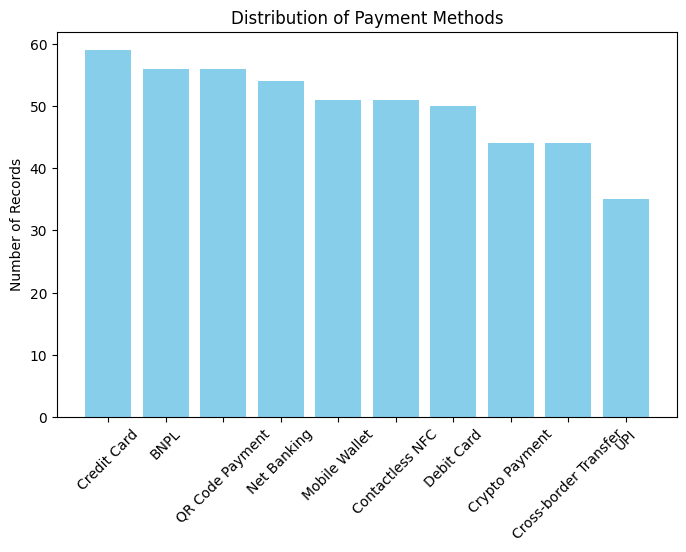

In [6]:
import matplotlib.pyplot as plt

# Count payment methods
method_counts = df.groupBy("payment_method").count().orderBy(col("count").desc())

# Convert to pandas for plotting
pdf = method_counts.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.bar(pdf["payment_method"], pdf["count"], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Number of Records")
plt.title("Distribution of Payment Methods")
plt.show()


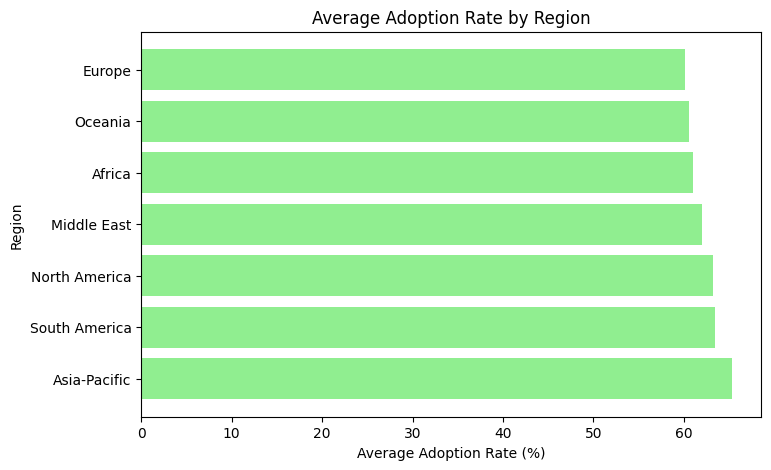

In [7]:
from pyspark.sql.functions import avg

# Calculate average adoption rate by region
region_avg = df.groupBy("region").agg(avg("adoption_rate_%").alias("avg_adoption")).orderBy(col("avg_adoption").desc())

# Convert to pandas
pdf = region_avg.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.barh(pdf["region"], pdf["avg_adoption"], color='lightgreen')
plt.xlabel("Average Adoption Rate (%)")
plt.ylabel("Region")
plt.title("Average Adoption Rate by Region")
plt.show()


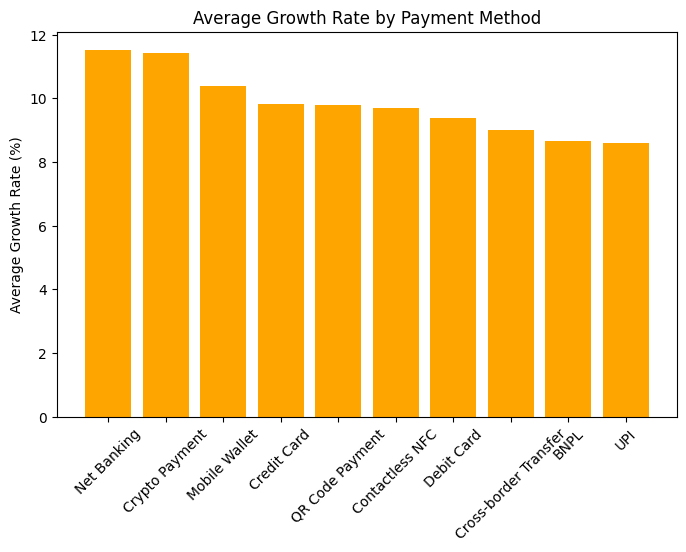

In [8]:
# Average growth rate by payment method
growth_avg = df.groupBy("payment_method").agg(avg("growth_rate_%").alias("avg_growth")).orderBy(col("avg_growth").desc())

# Convert to pandas
pdf = growth_avg.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.bar(pdf["payment_method"], pdf["avg_growth"], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Average Growth Rate (%)")
plt.title("Average Growth Rate by Payment Method")
plt.show()


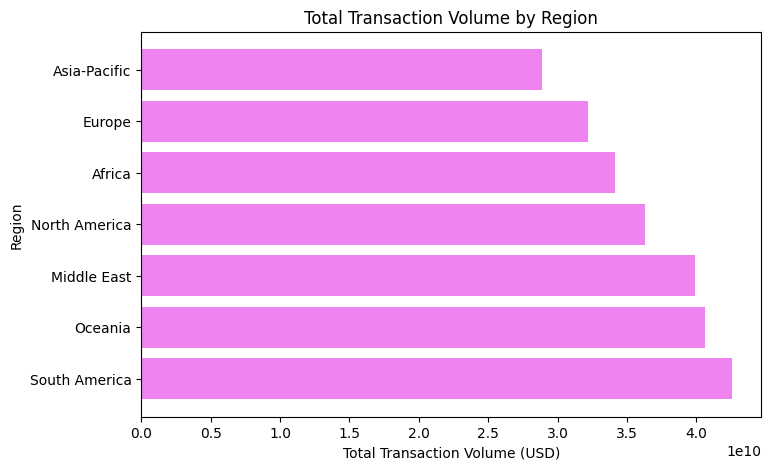

In [9]:
# Total transaction volume by region
region_volume = df.groupBy("region").agg(_sum("transaction_volume_usd").alias("total_volume")).orderBy(col("total_volume").desc())

# Convert to pandas
pdf = region_volume.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.barh(pdf["region"], pdf["total_volume"], color='violet')
plt.xlabel("Total Transaction Volume (USD)")
plt.ylabel("Region")
plt.title("Total Transaction Volume by Region")
plt.show()


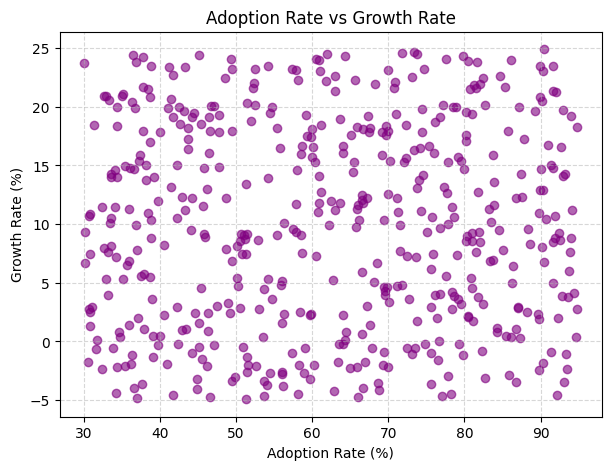

In [11]:
# Convert to pandas for scatter plot
pdf = df.select("adoption_rate_%", "growth_rate_%").toPandas()

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(pdf["adoption_rate_%"], pdf["growth_rate_%"], color='purple', alpha=0.6)
plt.xlabel("Adoption Rate (%)")
plt.ylabel("Growth Rate (%)")
plt.title("Adoption Rate vs Growth Rate")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



In [12]:
spark.stop()